In [1]:
#installing dependencies
!pip install -q pyspark findspark

In [2]:
# Initialise Spark to locate Java dependencies
import findspark
findspark.init()

#Pyspark for distributed data processing
import pyspark
from pyspark.sql import SparkSession #initialise spark
from pyspark.sql.functions import col, sum as _sum

#import standard Python libraries for data analysis and visualization
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
import matplotlib.pyplot as plt # Plotting
from matplotlib import colormaps # Access to color maps for plotting
import math # Mathematical utilities

import seaborn as sns # Statistical data visualization

> **⚠️ Prerequisite Notice**  
> This notebook uses Apache Spark via PySpark.  
> Please ensure you have **Java (JDK 8 or 11)** installed and properly configured on your syste Make sure the `JAVA_HOME` environment variable is set correctly and that `java.exe` is accessible in your system PATH.H.
>  
> Without Java, the Spark session will fail to initiale.



In [3]:
# Create a Spark session for distributed processing
spark = SparkSession.builder \
    .appName("Search Trends Analysis") \
    .getOrCreate()

While the dataset used in this thesis is relatively small and could have been handled entirely within Python's Pandas framework, PySpark was initially selected for its scalability and potential for distributed data processing.

# Google Trends keywords SVI data

In [4]:
#read CSV using Spark
df_kw = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_search_trends_keywords.csv', header=True, inferSchema=True) #inferSchema added to automatically type inference for columns
df_agg = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_search_trends_aggregated.csv', header=True, inferSchema=True)

## Google Trends keywords

In [5]:
#show preview keywords
df_kw.show(3)
df_kw.printSchema()

+----------+--------+-------+---------+-----------------------+-----------------+---------------+-------------------+----------------------------+------------------------------+---------------+--------------+-----------------+----------------+---------------+----+---------------------+-------------------+--------------------------+------------------+-------------------+---------------------+-------------+------------------+------------------+---------------+-------------------+------------------------+------------------------+---------------+--------------------+------+----------------+---------+------------+-------+----------------+----------------+---------------------+----+-------+----------------+--------------------+-------------------+----------------+-------------------+--------------+------------------------+
|      date|carefour|carfour|carrefour|carrefour autour de moi|carrefour near me|carrefour drive|carrefour livraison|carrefour livraison domicile|carrefour livraison Ã dom

Several columns appear to have only zero values; let's drop them and keep a list of these.

In [6]:
# Exclude 'date' column from processing
columns_to_check = [c for c in df_kw.columns if c != 'date']

In [7]:
#Drop columns (keywords) with only zero values in their cells
kept_cols = []
dropped_cols = []

# Loop through numeric columns only
for c in columns_to_check:
    try:
        col_sum = df_kw.select(_sum(col(f"`{c}`"))).collect()[0][0]     # Calculate sum of each keyword column, backticks in col() to safely reference columns like `E.Leclerc`
        if col_sum == 0 or col_sum is None:
            dropped_cols.append(c)  # Drop if column has no valid data
        else:
            kept_cols.append(c)
    except Exception as e:
        print(f"Skipping column '{c}' due to error: {e}")
        dropped_cols.append(c)

In [8]:
#Construct final list of columns to retain, keep 'date' and valid keyword columns
final_cols = ['date'] + kept_cols

# Select cleaned/filtered DataFrame
df_kw_cleaned = df_kw.select(*[col(c) if c == 'date' else col(f"`{c}`") for c in final_cols])

In [71]:
# Show results
print("Dropped columns (all values were 0 or null):")
print(dropped_cols)

Dropped columns (all values were 0 or null):
['carfour', 'carrefour near me', 'IntermarchÃ©', 'carrefour bourse']


✅ Dropped columns (all values were 0 or null):

`carfour`, `carrefour near me`, `IntermarchÃ©`, `carrefour bourse`.

In [124]:
# Preview the first 3 rows of the cleaned dataset
df_kw_cleaned.show(3)

+----------+--------+---------+-----------------------+---------------+-------------------+----------------------------+------------------------------+---------------+--------------+-----------------+----------------+---------------+----+---------------------+-------------------+--------------------------+------------------+-------------------+---------------------+-------------+------------------+------------------+---------------+-------------------+------------------------+------------------------+---------------+--------------------+------+----------------+---------+-------+----------------+---------------------+----+-------+----------------+--------------------+-------------------+----------------+-------------------+--------------+------------------------+
|      date|carefour|carrefour|carrefour autour de moi|carrefour drive|carrefour livraison|carrefour livraison domicile|carrefour livraison Ã domicile|drive carrefour|carrefour city|carrefour express|carrefour market|carrefour 

### EDA

In [9]:
# Convert PySpark DataFrame to Pandas
df_kw_pd = df_kw_cleaned.toPandas()

In [10]:
# Check the dimensions of the DataFrame
df_kw_pd.shape

(178, 44)

#### 1. Date Handling & Time Index Setup

The `date` is currently in ISO 8601 standard, `yyyy-mm-dd`, making it directly compatible with pandas and the libraries we will use.

However, we will convert the date to a Datetime object to fully utilise the time series functionalities. Lastly, we will set it as the DataFrame index, which converts the DataFrame into a time series for slicing, plotting, and modelling.

In [11]:
# Convert 'date' column to datetime and set as index
df_kw_pd['date'] = pd.to_datetime(df_kw_pd['date'])
df_kw_pd.set_index('date', inplace=True)
df_kw_pd.sort_index(inplace=True) #sorts data chronologically from earliest to latest data

#### 2. Time Series Grid of Keywords

In [76]:
# Set up subplot grid
n_keywords = len(df_kw_pd.columns)
n_cols = 4
n_rows = math.ceil(n_keywords / n_cols)

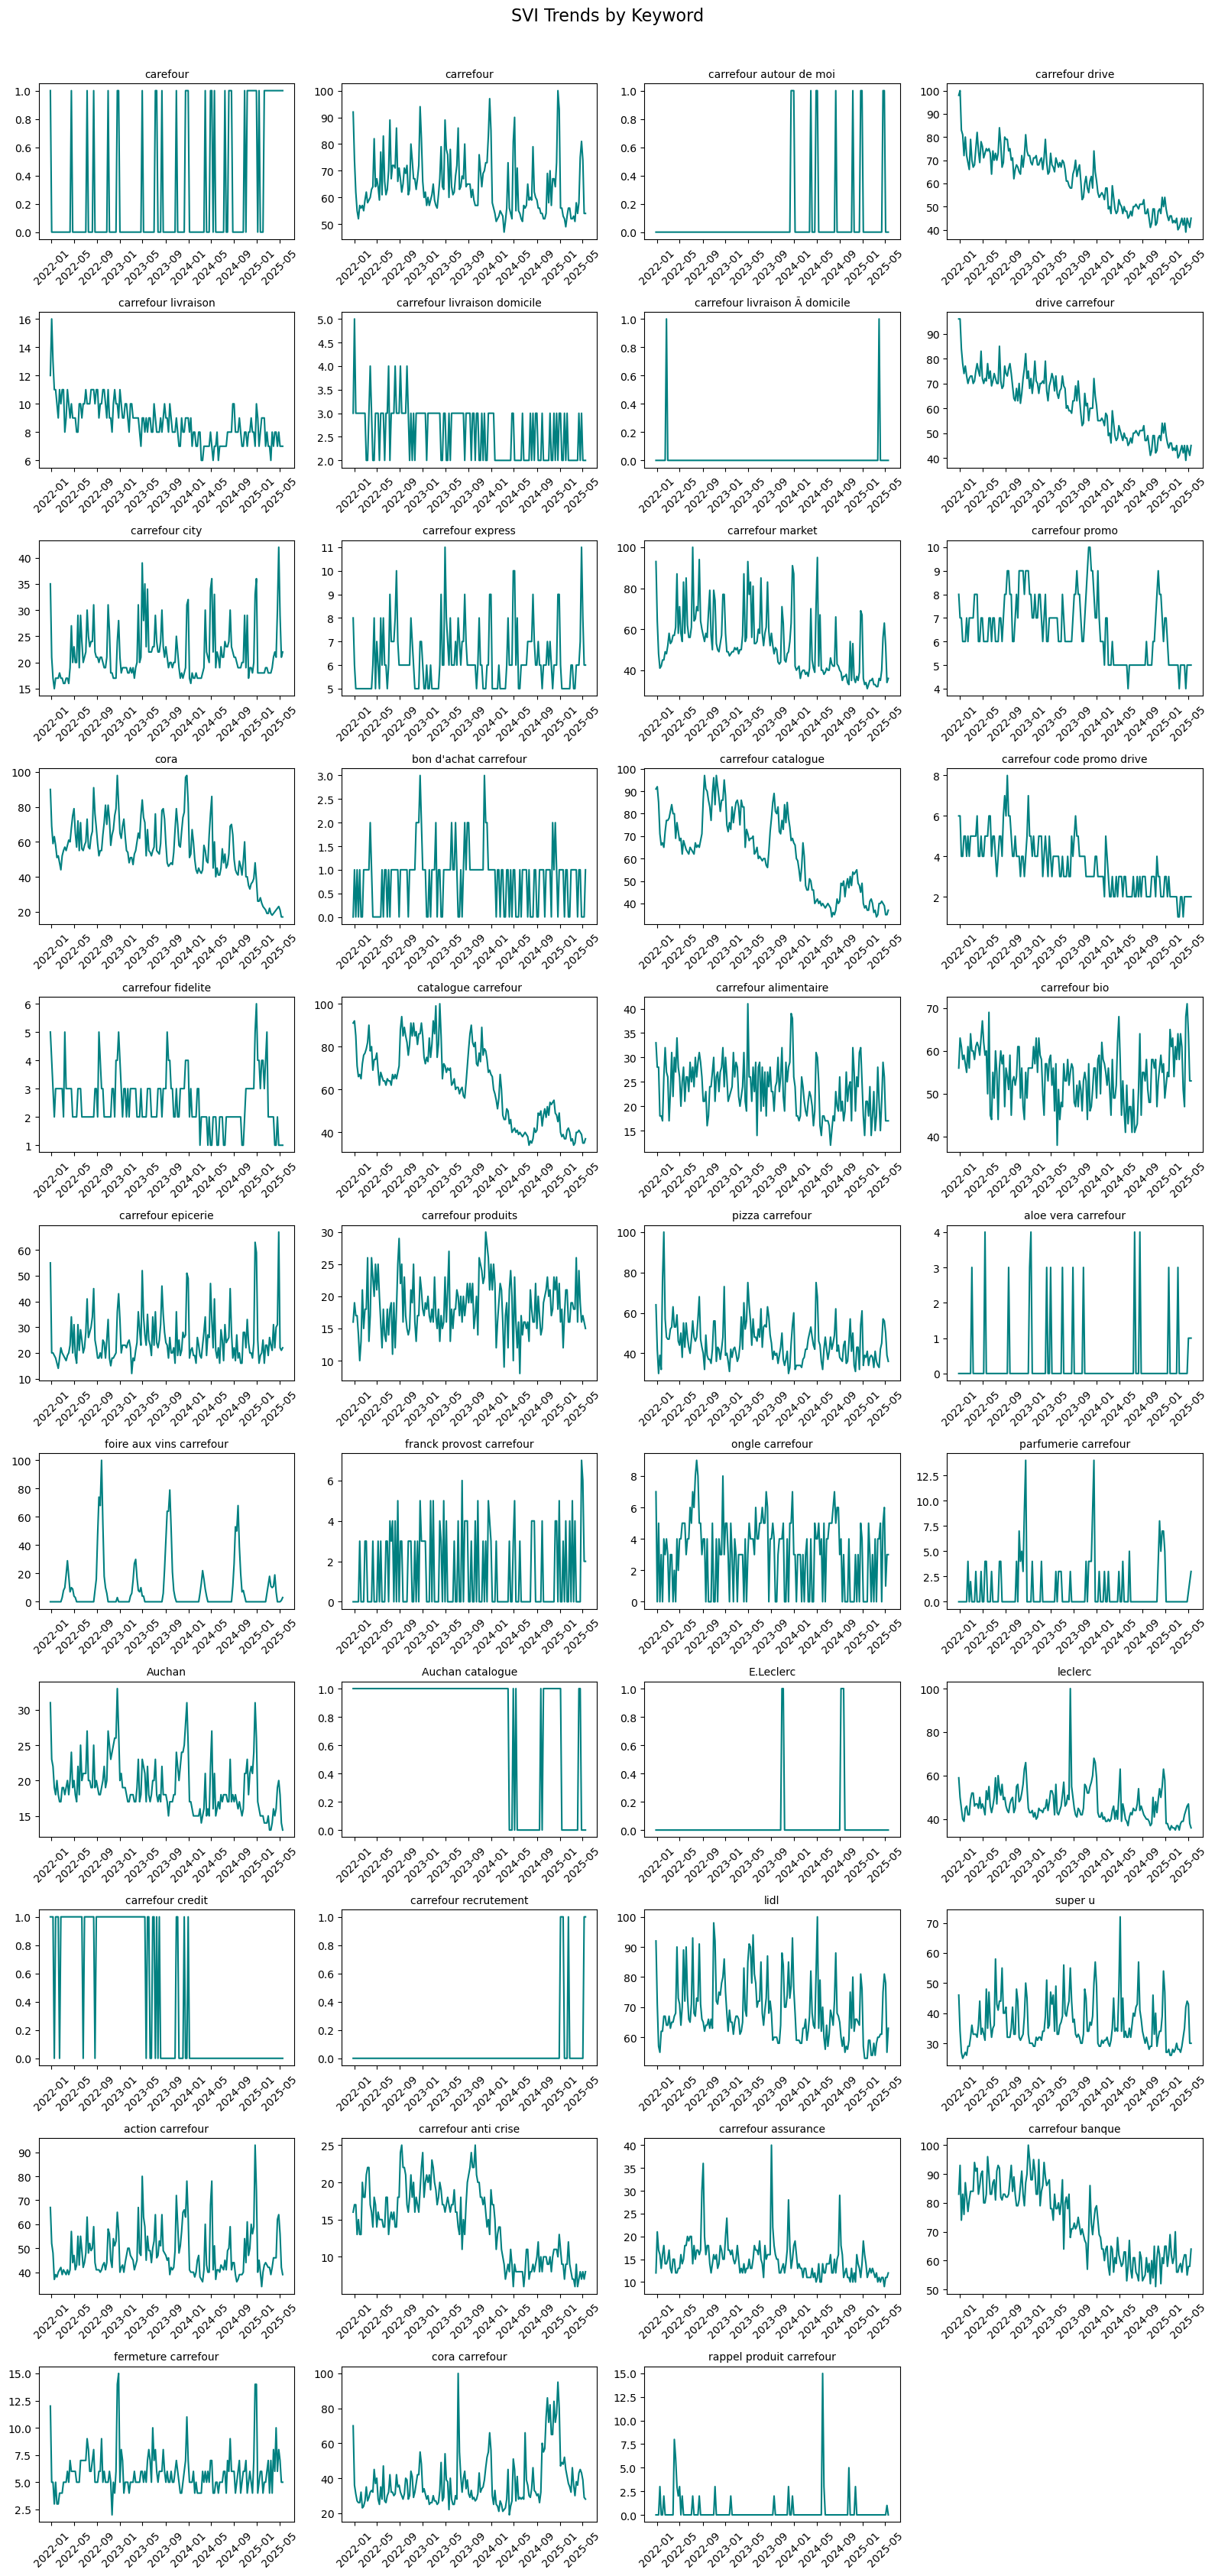

<Figure size 640x480 with 0 Axes>

In [77]:
#plot grid
plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, keyword in enumerate(df_kw_pd.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(df_kw_pd.index, df_kw_pd[keyword], color='teal')
    plt.title(keyword, fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle("SVI Trends by Keyword", fontsize=16, y=1.02)
plt.show()
#save figure as png
plt.savefig('svi_keyword_trends.png', bbox_inches='tight', dpi=300)

As expected based on the literature review, we observe considerable variability in search popularity over time for most keywords, with episodic peaks in search interest. We can also see the sudden rise in popularity of some keywords over time and the decline of others.

#### 3. Distribution Plot of Interest Scores

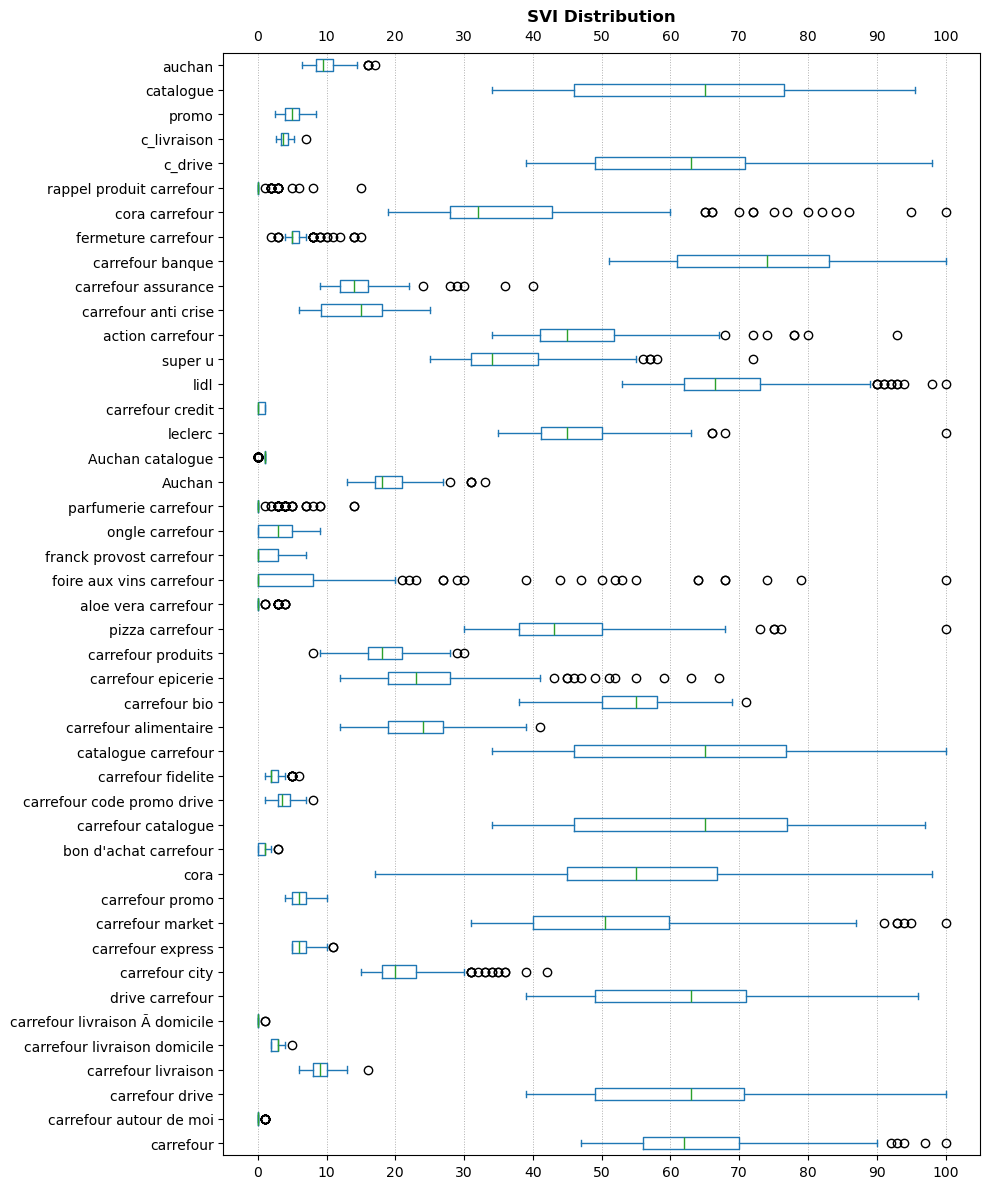

In [126]:
# Create horizontal boxplots for each keyword's SVI distribution
df_kw_pd.plot(kind='box', vert=False, figsize=(10, 12), title='SVI Distribution')
plt.title('SVI Distribution', fontweight='bold')
plt.tick_params(axis='x', which='both', labeltop=True)
plt.grid(axis='x', linestyle=':', linewidth=0.7)
plt.xticks(np.arange(0, 110, 10))
plt.tight_layout()

#save figure as png
plt.savefig('svi_distribution_boxplot.png', bbox_inches='tight', dpi=300)

plt.show()

#### 4. Statistical Summary

In [11]:
# Generate summary statistics for all keywords
summary = df_kw_pd.describe().T

In [12]:
# Compute additional statistics: range, IQR, skew, kurtosis, volatility
summary["range"] = summary["max"] - summary["min"]
summary["iqr"] = summary["75%"] - summary["25%"] #interquartile range
summary["skew"] = df_kw_pd.skew()
summary["kurtosis"] = df_kw_pd.kurtosis()
summary["volatility (std/mean)"] = summary["std"] / summary["mean"]

In [13]:
# Display the updated summary statistics
summary

,count,mean,std,min,25%,50%,75%,max,range,iqr,skew,kurtosis,volatility (std/mean)
carefour,178.0,0.269663,0.445037,0.0,0.00,0.0,1.00,1.0,1.0,1.00,1.046901,-0.914401,1.650344
carrefour,178.0,64.342697,10.632031,47.0,56.00,62.0,70.00,100.0,53.0,14.00,1.060975,0.806986,0.165241
carrefour autour de moi,178.0,0.067416,0.251448,0.0,0.00,0.0,0.00,1.0,1.0,0.00,3.479846,10.224086,3.729811
carrefour drive,178.0,61.028090,12.453498,39.0,49.00,63.0,70.75,100.0,61.0,21.75,0.178096,-0.572171,0.204062
carrefour livraison,178.0,8.707865,1.466787,6.0,8.00,9.0,10.00,16.0,10.0,2.00,0.887543,2.499696,0.168444
carrefour livraison domicile,178.0,2.606742,0.574761,2.0,2.00,3.0,3.00,5.0,3.0,1.00,0.475760,0.394989,0.220490
carrefour livraison Ã domicile,178.0,0.011236,0.105700,0.0,0.00,0.0,0.00,1.0,1.0,0.00,9.353236,86.454352,9.407294
drive carrefour,178.0,61.067416,12.420866,39.0,49.00,63.0,71.00,96.0,57.0,22.00,0.098069,-0.837158,0.203396
carrefour city,178.0,21.747191,5.084386,15.0,18.00,20.0,23.00,42.0,27.0,5.00,1.539816,2.079072,0.233795
carrefour express,178.0,6.213483,1.288558,5.0,5.00,6.0,7.00,11.0,6.0,2.00,1.436954,2.065717,0.207381


##### Mean
A few keywords stand above the others with a mean above 60, indicating dominant and sustained search behaviour: 
"carrefour banque" ~73, "lidl" ~68, "carrefour" ~64, "catalogue carrefour"	~62, "carrefour catalogue"	~62, "drive carrefour"	~61, "carrefour drive"	~61

##### Standard Deviation
With a sigma above ~17, the following keywords showcase the highest volatility in search patterns: "catalogue carrefour", "carrefour catalogue", "cora", "foire aux vins carrefour".

##### Range (max-min)
Several FMCG-related and brand name keywords are acarcterised with wide fluctuations in attention (range above 50): "foire aux vins carrefour", "pizza carrefour", "carrefour", "cora carrefour", "cora", "carrefour market", "leclerc".

##### Skewness and Kurtosis
A few keywords have a negative skew, with only "Auchan catalogue" having a skewness above -1.0. Interestingly, "carrefour livraison Ã domicile", "rappel produit carrefour", "E.Leclerc" and "carrefour recrutement" have a significant positive skeweness (all above +5.0), indicating a low search interest with occasional spikes in interest. These same keywords are also the ones with the highest kurtosis, suggesting strong event-driven behaviour. Based on the meaning of the keywords, we can see that this is possibly related to news or exceptional occasions ("rappel produit carrefour" and "E.Leclerc") or seasonal events ("carrefour recrutement").

##### Volatility (std/mean)
Based on the data, we can set the volatility thresholds as follows:
* below 0.20 Low: most of these keywords are brand equity
* 0.20 – 0.50 Medium: keywords here seem to be related to FMCG sales cycles
* 0.50 – 1.0 High: keywords in this group are possibly linked to events as they have high variance in consumer interest.
* above 1.0 Very High: these keywords might be helpful for short-term forecasting or anomaly analysis.

#### 5. Missing Values Analysis
Check how much missing and flat data there is with visuals.

In [12]:
# Check for any columns with missing values
missing = df_kw_pd.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("Columns with missing values:")
    print(missing)
else:
    print("No missing values found.")


No missing values found.


In [13]:
# Check how many zero values exist per column
zeros = (df_kw_pd == 0).sum()
zeros = zeros[zeros > 0]

if not zeros.empty:
    print("Number of zeros in columns:")
    print(zeros)
else:
    print("No columns with zeros values found.")


Number of zeros in columns:
carefour                          130
carrefour autour de moi           166
carrefour livraison Ã domicile    176
bon d'achat carrefour              52
aloe vera carrefour               161
foire aux vins carrefour          109
franck provost carrefour          112
ongle carrefour                    51
parfumerie carrefour              134
Auchan catalogue                   40
E.Leclerc                         173
carrefour credit                   99
carrefour recrutement             172
rappel produit carrefour          158
dtype: int64


Keywords with many zero values might have episodic or accidental search interest; these will be monitored throughout the rest of the EDA.

#### 6. Keyword Correlation Matrix

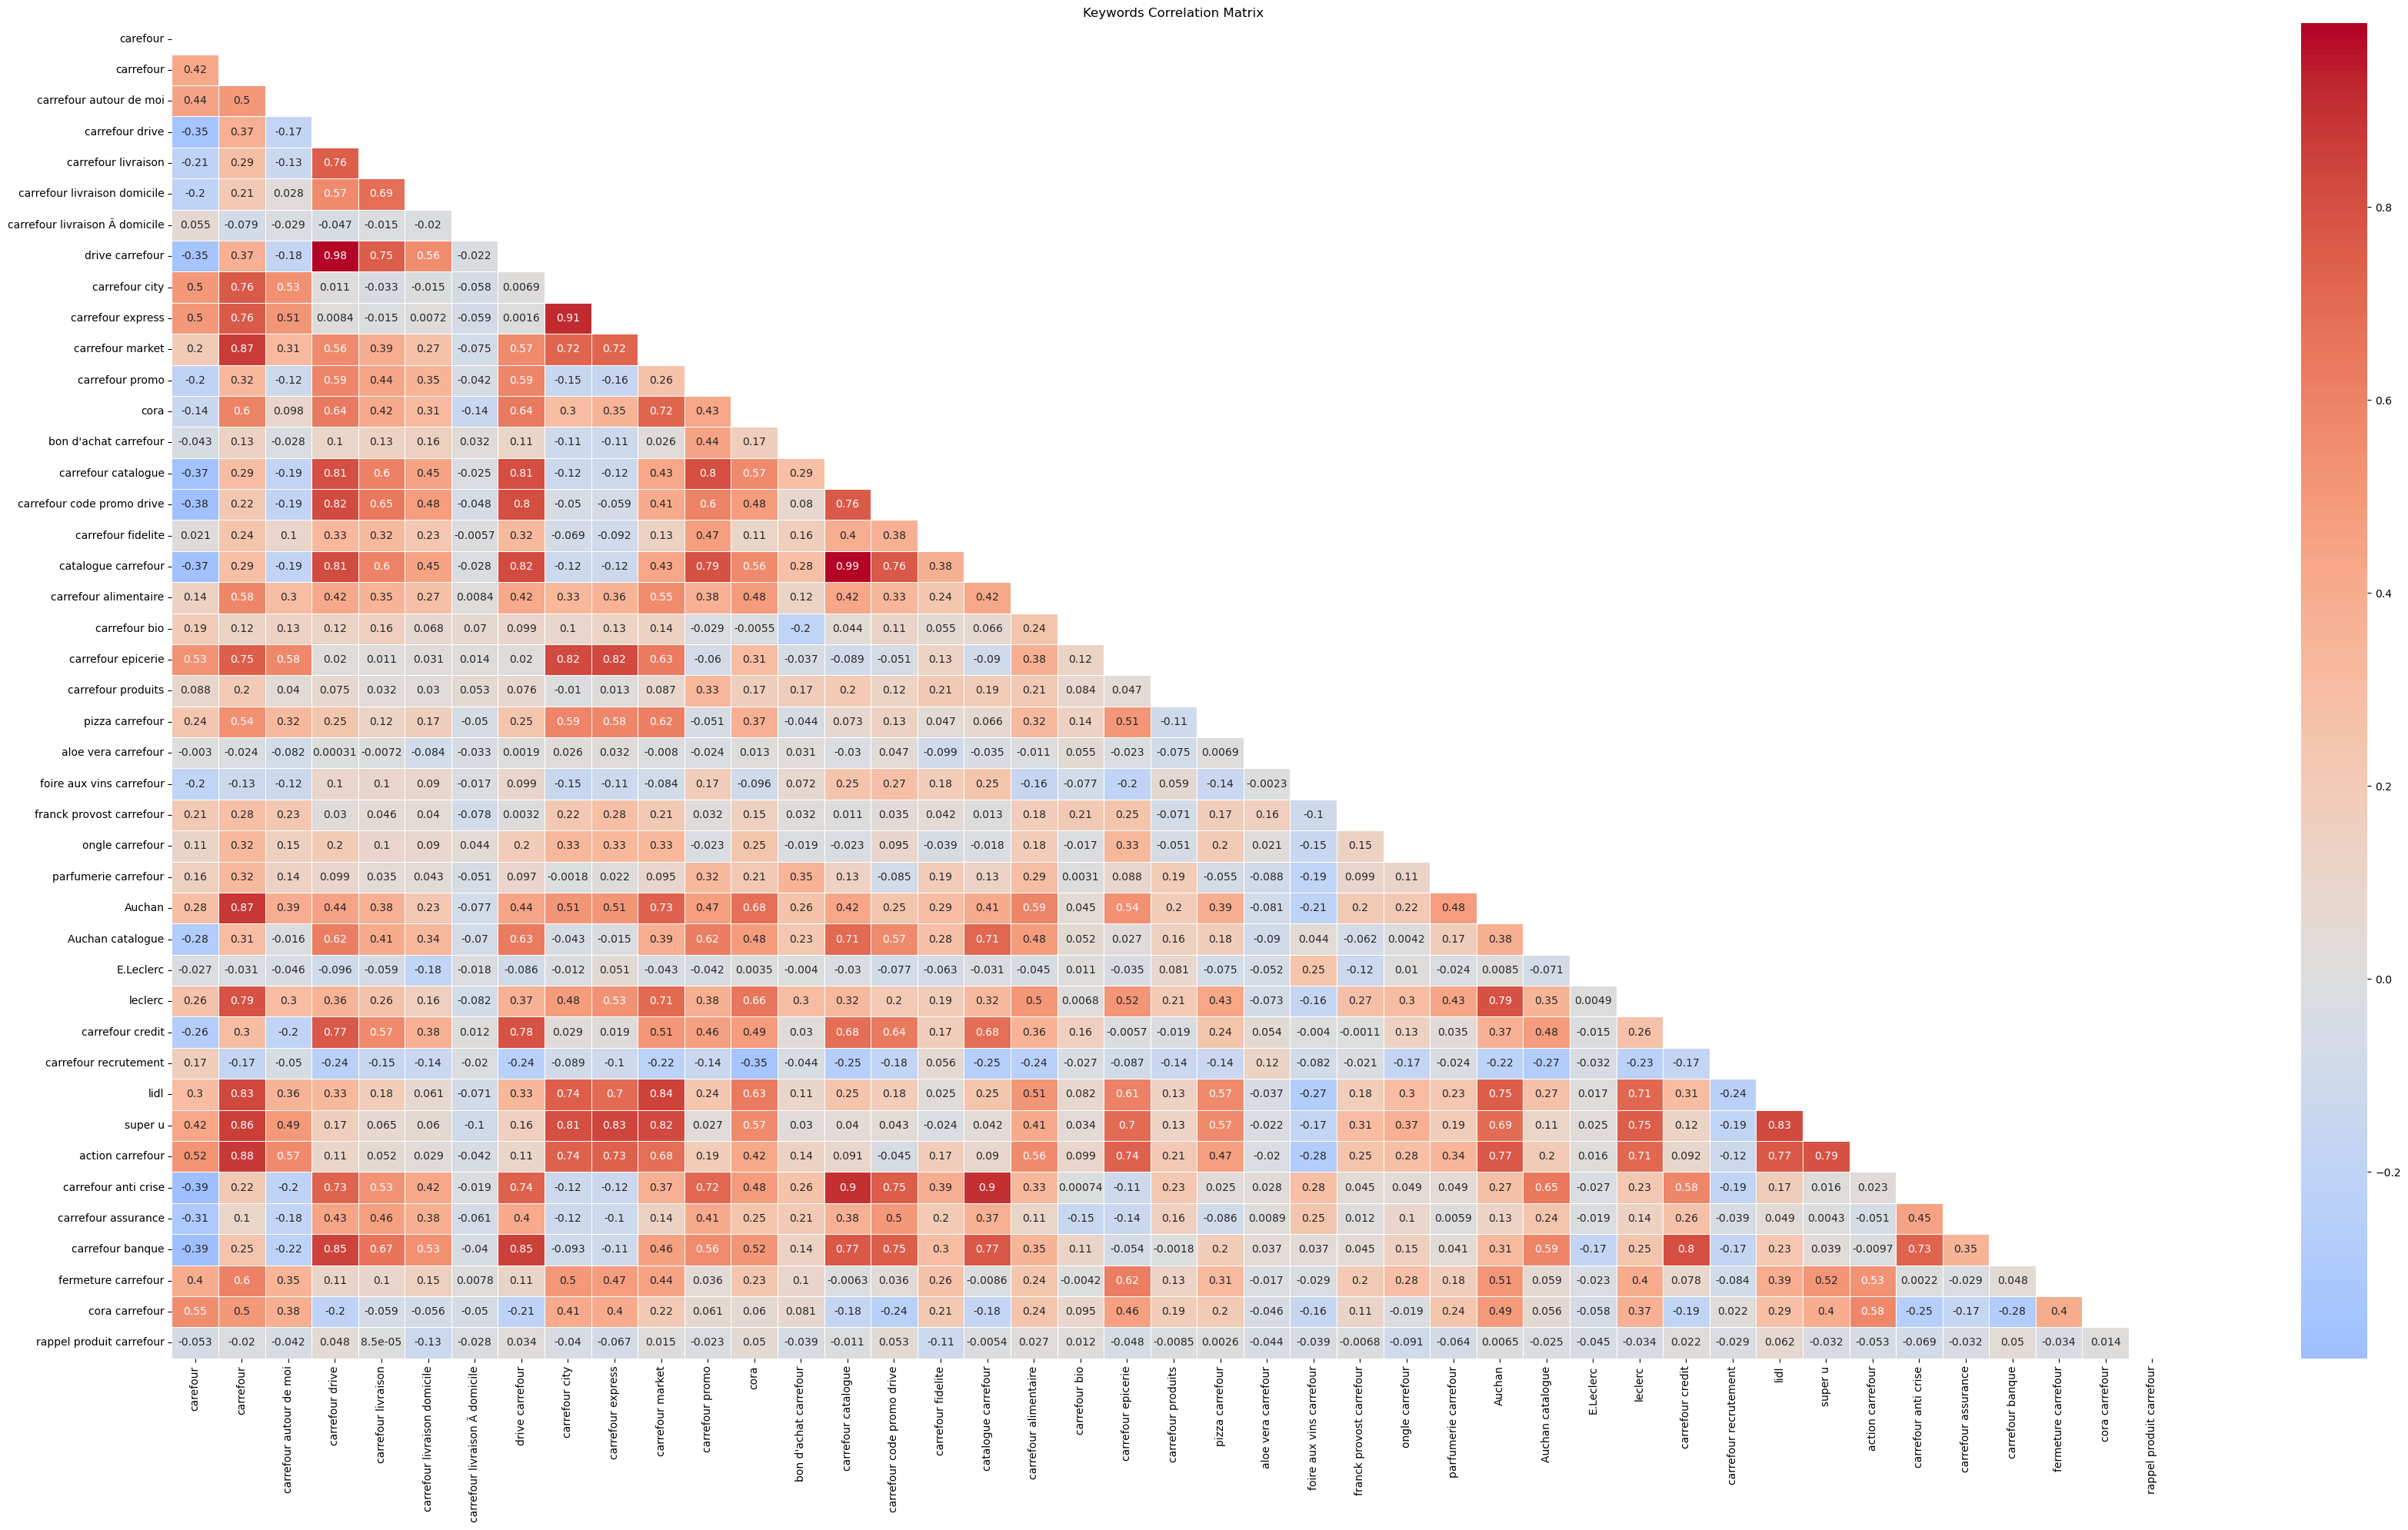

In [84]:
# Plot heatmap of correlation matrix for keyword search trends
corr = df_kw_pd.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(35, 20))
sns.heatmap(corr, 
            mask=mask, 
            cmap='coolwarm', 
            center=0, 
            linewidths=0.5, 
            annot=True)
plt.title("Keywords Correlation Matrix")
plt.tight_layout()

#save figure as png
plt.savefig('svi_correlation_matrix.png', bbox_inches='tight', dpi=300)

plt.show()

In [85]:
# Transform correlation matrix into list and categorise correlation strength
corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['Keyword1', 'Keyword2', 'Correlation']

def categorize_corr(value):
    if value >= 0.8:
        return 'High Positive'
    elif value <= -0.8:
        return 'High Negative'
    elif value >= 0.4:
        return 'Average Positive'
    elif value <= -0.4:
        return 'Average Negative'
    elif value >= 0.0:
        return 'Low Positive'
    elif value > -0.4:
        return 'Low Negative'
    else:
        value
        return 'Negative'

corr_pairs['Category'] = corr_pairs['Correlation'].apply(categorize_corr)

##### HIGH CORRELATION PAIRS

In [86]:
# Display keyword pairs with high correlations
high_corr = corr_pairs[corr_pairs['Category'].isin(['High Positive', 'High Negative'])]
print(high_corr.to_string(index=False))

           Keyword1                   Keyword2  Correlation      Category
          carrefour           carrefour market     0.868893 High Positive
          carrefour                     Auchan     0.874106 High Positive
          carrefour                       lidl     0.831955 High Positive
          carrefour                    super u     0.860109 High Positive
          carrefour           action carrefour     0.876313 High Positive
    carrefour drive            drive carrefour     0.981436 High Positive
    carrefour drive        carrefour catalogue     0.807754 High Positive
    carrefour drive carrefour code promo drive     0.816569 High Positive
    carrefour drive        catalogue carrefour     0.814820 High Positive
    carrefour drive           carrefour banque     0.846021 High Positive
    drive carrefour        carrefour catalogue     0.810264 High Positive
    drive carrefour carrefour code promo drive     0.802074 High Positive
    drive carrefour        catalogue c

Highly correlated keywords are all positive indicating a strong linear positive correlation.

* Carrefour and its sub-brands/services show consistently high correlations, suggesting that interest in Carrefour as a brand is strongly tied to its different offerings.
* Consumers frequently search promotions or catalogues in conjunction with drive-related services.
* Strong correlation between Carrefour and competitors, suggesting that users often compare multiple grocery retailers in the same session or buying cycle.
* High correlation between localised formats, confirming the literature as of France's interest in urban and convenience-oriented store formats

##### AVERAGE CORRELATION PAIRS

Reflect moderately aligned but differentiated consumer behaviours.

In [87]:
# Display keyword pairs with average correlations
avg_corr = corr_pairs[corr_pairs['Category'].isin(['Average Positive', 'Average Negative'])]
print(avg_corr.to_string(index=False))

                    Keyword1                     Keyword2  Correlation         Category
                    carefour                    carrefour     0.420956 Average Positive
                    carefour      carrefour autour de moi     0.442474 Average Positive
                    carefour               carrefour city     0.499707 Average Positive
                    carefour            carrefour express     0.500020 Average Positive
                    carefour           carrefour epicerie     0.525883 Average Positive
                    carefour                      super u     0.424075 Average Positive
                    carefour             action carrefour     0.522155 Average Positive
                    carefour               cora carrefour     0.550883 Average Positive
                   carrefour      carrefour autour de moi     0.496390 Average Positive
                   carrefour               carrefour city     0.762156 Average Positive
                   carrefour    

##### LOW CORRELATION PAIRS

In [88]:
# Display keyword pairs with low correlations
low_corr = corr_pairs[corr_pairs['Category'].isin(['Low Positive', 'Low Negative'])]
print(low_corr.to_string(index=False))

                      Keyword1                       Keyword2  Correlation     Category
                      carefour                carrefour drive    -0.348986 Low Negative
                      carefour            carrefour livraison    -0.207524 Low Negative
                      carefour   carrefour livraison domicile    -0.201516 Low Negative
                      carefour carrefour livraison Ã domicile     0.055329 Low Positive
                      carefour                drive carrefour    -0.345700 Low Negative
                      carefour               carrefour market     0.196291 Low Positive
                      carefour                carrefour promo    -0.202750 Low Negative
                      carefour                           cora    -0.135878 Low Negative
                      carefour          bon d'achat carrefour    -0.042758 Low Negative
                      carefour            carrefour catalogue    -0.365542 Low Negative
                      carefour  

**Positive Low Correlations**
* Product-specific keywords (aloe vera, pizza, ongle carrefour) often exhibit isolated behaviours, hinting at niche shopping intent or product-specific campaigns.

**Negative Correlations**
* These pairs indicate weak or diverging search behaviour, which may suggest: niche interest, separate consumer journeys, misalignment in search intent or timing.
* `carefour` (misspelt) has several negative correlations (`carrefour drive` (-0.35), `carrefour promo` (-0.20), `carrefour catalogue` (-0.36)), suggesting noise or irrelevant intent behind this keyword.

##### Conclusions
Based on the descriptive analysis, count of zeros in the columns, and correlation matrix, we can state the following for our analysis:

* `carefour`: Highly noisy and negatively correlated with most Carrefour terms, it will be removed as it may not be relevant. 
* `carrefour livraison à domicile`: Sparse and episodic search behaviour, will be aggregated with `carrefour livraison domicile`.
* `aloe vera carrefour`: Niche product search, best to aggregate it with other FMCG keywords.
* `E.Leclerc`: inconsistent sample, best to remove as there is already the `lecerc` keyword fulfilling the same search intent.
* `carrefour recrutement`: Episodic search, while it possibly follows a seasonal recruitment pattern, it has too little data to provide insight fully.
* `rappel produit carrefour`: Event-driven; behaves independently from regular consumer patterns.

In [14]:
#drop desired keywords
df_kw_pd = df_kw_pd.drop(columns=["carefour", "E.Leclerc", "carrefour recrutement"])

In [15]:
# Check the dimensions of the DataFrame
df_kw_pd.shape

(178, 40)

## Google Trends keywords aggregated

Based on search intent, keywords can be aggregated as follows:

> ⚠️ keywords marked as ~~keywords~~ are those dropped after the initial EDA

| Aggregate | Keywords | Justification |
|---|---|---|
| Brand | carrefour, carrefour autour de moi, ~~carrefour near me~~, ~~carfour~~, ~~carefour~~ | Serves as an anchor term to capture general brand interest and visibility. |
| Service and logistics | carrefour drive, drive carrefour, carrefour livraison, carrefour livraison domicile, carrefour livraison Ã domicile | Reflects consumer demand for fulfilment services such as click-and-collect and home delivery, indicating operational engagement. |
| Sub-brand | carrefour market, carrefour city, carrefour express, cora | Provides more granular insight into Carrefour’s diversified retail formats and regional presence. |
| Promo and engagement | carrefour promo, carrefour code promo drive, carrefour catalogue, catalogue carrefour, carrefour fidelite, bon d'achat carrefour | Captures interest in promotions, loyalty programs, and catalogues; key drivers of footfall and conversion in price-sensitive FMCG segments. |
| FMCG products | carrefour produits, carrefour alimentaire, carrefour epicerie, carrefour bio, pizza carrefour, foire aux vins carrefour, ongle carrefour, franck provost carrefour, parfumerie carrefour, aloe vera carrefour | Reflects consumer preferences for specific product categories; interest in organic and beauty items may indicate evolving lifestyle and sustainability trends. |
| Competitors | Auchan, Auchan catalogue, ~~E.Leclerc~~, leclerc, ~~IntermarchÃ©~~, lidl, super u  | Rising interest in competing retailers may signal market share shifts or influence investor sentiment regarding Carrefour. |
| Finance | ~~carrefour bourse~~, ~~carrefour recrutement~~, carrefour credit, carrefour assurance, action carrefour, carrefour banque, carrefour anti crise | Indicates public engagement with Carrefour’s financial operations, job market relevance, and economic resilience. |
| News  | fermeture carrefour, rappel produit carrefour, cora carrefour | Tracks external news-driven factors, including store closures and product recalls, which may impact consumer trust or financial outlook. |

In [91]:
#show preview keywords
df_agg.show(5)
df_agg.printSchema()

+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
|      date|Brand|Competitors|FMCG products|Finance|News|Promo and engagement|Service and logistics|Sub-brand|
+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
|26/12/2021|   93|        229|          231|    179|  82|                 201|                  209|      226|
|02/01/2022|   74|        179|          172|    184|  41|                 202|                  217|      160|
|09/01/2022|   62|        152|          161|    157|  36|                 184|                  183|      129|
|16/01/2022|   55|        140|          151|    149|  33|                 155|                  173|      124|
|23/01/2022|   52|        146|          144|    144|  31|                 146|                  160|      122|
+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
o

In [16]:
# Convert PySpark DataFrame to Pandas
df_agg_pd_ = df_agg.toPandas()

In [17]:
# Ensure 'date' column is datetime and set it as the index
df_agg_pd_['date'] = pd.to_datetime(df_agg_pd_['date'], dayfirst=True)
df_agg_pd_.set_index('date', inplace=True)

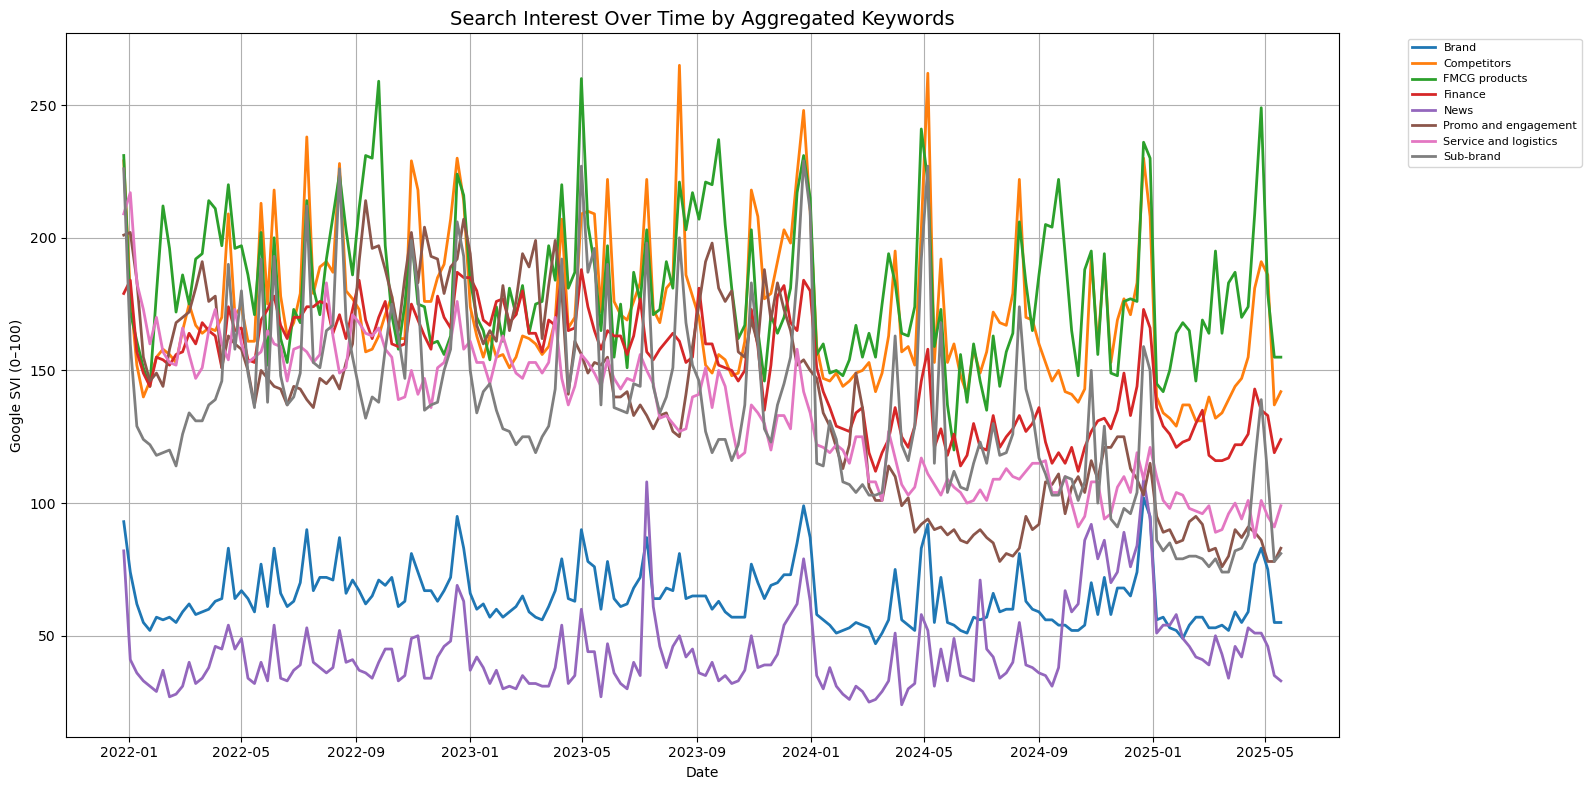

In [94]:
# Plotting all keywords 
plt.figure(figsize=(16, 8))

for keyword in df_agg_pd_.columns:
    plt.plot(df_agg_pd_.index, df_agg_pd_[keyword], label=keyword, linewidth=2)

plt.title("Search Interest Over Time by Aggregated Keywords", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Google SVI (0–100)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

The aggregation of the SVI data in the `carrefour_search_trends_aggregated.csv` was initially performed at the data collection stage in the following manner: 
- one column for each aggregated category (as defined in the table above);
- each row represents a time period with weekly frequency;
- each value is the sum of the SVI values for all keywords belonging to that category at that point in time.

However, this initial aggregation method is methodologically unsatisfactory. In Google Trends each keyword's SVI is scaled individually (where 0 represent the lowest relative search interest and 100 the peak relative interest within the time range selected), therefore, summing across keywords combines values on different scales. As such we risk overemphasising categories with more keywords and introduce bias if some keywords exhibit greater volatility than others.

To enhance the interpretability and methodological robustness of the analysis, alternative aggregation techniques should be considered:

| Aggregation Method   | Analysis   | 
|:---|:---|
| Simple mean | Assigns equal weight to all keywords, avoids keyword-count bias, and is easy to interpret. |
| Weighted mean | Offers higher accuracy if reliable weights (e.g., based on historical correlation or relevance) are available. |
| Z-score normalised mean | Standardises keyword volatility and expresses interest relative to each keyword’s historical mean. |
| Median | More robust to outliers and episodic spikes, especially useful with erratic or sparse search data. |
| Principal component aggregation (PCA) | Extracts the dominant shared pattern across keywords, ideal when a common driver is expected. |
| Maximum value (peak interest) | Highlights the most significant surge in attention per period, suitable for tracking event-driven spikes. |
| Frequency-based binary aggregation | Converts SVIs into binary indicators (e.g., 1 if above threshold), capturing the breadth of search interest per category. |

Using the mean as the aggregation method is likely the most appropriate option, as it mitigates the bias of differing keyword counts while also offering an intuitive measure of category-level search interest. However, to avoid weight bias, keywords with almost equal search intent will be aggregated separately first; these are:
* "carrefour drive", "drive carrefour"
* "carrefour livraison", "carrefour livraison domicile", "carrefour livraison Ã domicile"
* "carrefour promo", "carrefour code promo drive"
* "carrefour catalogue", "catalogue carrefour"
* "Auchan", "Auchan catalogue"

In [18]:
# Averaging specified keywords and creating new merged columns using df_kw_pd
df_kw_pd["c_drive"] = df_kw_pd[["carrefour drive", "drive carrefour"]].mean(axis=1)
df_kw_pd["c_livraison"] = df_kw_pd[["carrefour livraison", "carrefour livraison domicile", "carrefour livraison Ã domicile"]].mean(axis=1)
df_kw_pd["promo"] = df_kw_pd[["carrefour promo", "carrefour code promo drive"]].mean(axis=1)
df_kw_pd["catalogue"] = df_kw_pd[["carrefour catalogue", "catalogue carrefour"]].mean(axis=1)
df_kw_pd["auchan"] = df_kw_pd[["Auchan", "Auchan catalogue"]].mean(axis=1)

In [19]:
#dropping old keywords now merged
df_agg_pd = df_kw_pd.drop(columns=[
    "carrefour drive", "drive carrefour",
    "carrefour livraison", "carrefour livraison domicile", "carrefour livraison Ã domicile",
    "carrefour promo", "carrefour code promo drive",
    "carrefour catalogue", "catalogue carrefour",
    "Auchan", "Auchan catalogue"
])

In [20]:
# Check the dimensions of the DataFrame
df_agg_pd.shape

(178, 34)

In [21]:
# Check the dimensions of the DataFrame
df_agg_pd.columns 

Index(['carrefour', 'carrefour autour de moi', 'carrefour city',
       'carrefour express', 'carrefour market', 'cora',
       'bon d'achat carrefour', 'carrefour fidelite', 'carrefour alimentaire',
       'carrefour bio', 'carrefour epicerie', 'carrefour produits',
       'pizza carrefour', 'aloe vera carrefour', 'foire aux vins carrefour',
       'franck provost carrefour', 'ongle carrefour', 'parfumerie carrefour',
       'leclerc', 'carrefour credit', 'lidl', 'super u', 'action carrefour',
       'carrefour anti crise', 'carrefour assurance', 'carrefour banque',
       'fermeture carrefour', 'cora carrefour', 'rappel produit carrefour',
       'c_drive', 'c_livraison', 'promo', 'catalogue', 'auchan'],
      dtype='object')

In [22]:
#aggregating variables based on category
df_agg_pd["brand"] = df_kw_pd[["carrefour", "carrefour autour de moi"]].mean(axis=1)
df_agg_pd["service"] = df_kw_pd[["c_drive", "c_livraison"]].mean(axis=1)
df_agg_pd["sub-brand"] = df_kw_pd[["carrefour market", "carrefour city", "carrefour express", "cora"]].mean(axis=1)
df_agg_pd["promo"] = df_kw_pd[["promo", "catalogue", "carrefour fidelite", "bon d'achat carrefour"]].mean(axis=1)
df_agg_pd["fmcg"] = df_kw_pd[["carrefour produits", "carrefour alimentaire", "carrefour epicerie", "carrefour bio", "pizza carrefour", "foire aux vins carrefour", "ongle carrefour", "franck provost carrefour", "parfumerie carrefour", "aloe vera carrefour"]].mean(axis=1)
df_agg_pd["competitors"] = df_kw_pd[["auchan", "leclerc", "lidl", "super u"]].mean(axis=1)
df_agg_pd["finance"] = df_kw_pd[["carrefour credit", "carrefour assurance", "action carrefour", "carrefour banque", "carrefour anti crise"]].mean(axis=1)
df_agg_pd["news"] = df_kw_pd[["fermeture carrefour", "rappel produit carrefour", "cora carrefour"]].mean(axis=1)

In [23]:
#dropping old keywords now merged
df_agg_final = df_agg_pd.drop(columns=[
    "carrefour", "carrefour autour de moi", "carrefour city",
    "carrefour express", "carrefour market", "cora", "bon d'achat carrefour",
    "carrefour fidelite", "carrefour alimentaire", "carrefour bio", "carrefour epicerie", "carrefour produits",
    "pizza carrefour", "aloe vera carrefour", "foire aux vins carrefour",
    "franck provost carrefour", "ongle carrefour", "parfumerie carrefour",
    "leclerc", "carrefour credit", "lidl", "super u", "action carrefour",
    "carrefour anti crise", "carrefour assurance", "carrefour banque",
    "fermeture carrefour", "cora carrefour", "rappel produit carrefour",
    "c_drive", "c_livraison", "promo", "catalogue", "auchan"  # fixed here
])

In [24]:
# Check the dimensions of the DataFrame
df_agg_final.shape

(178, 7)

In [27]:
# Check the dimensions of the DataFrame
df_agg_final.columns 

Index(['brand', 'service', 'sub-brand', 'fmcg', 'competitors', 'finance',
       'news'],
      dtype='object')

### EDA Aggregated DataFrame df_agg_final

##### 1. Statistical Summary

In [28]:
# Generate summary statistics for aggregated SVI data
df_agg_final.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,178.0,32.205056,5.379531,23.500,28.000000,31.00,35.000000,50.500000
service,178.0,32.411517,6.431920,21.000,26.375000,33.25,37.458333,52.500000
sub-brand,178.0,33.943820,8.642193,18.500,28.750000,33.50,37.750000,57.250000
fmcg,178.0,18.134270,2.653173,12.000,16.300000,17.50,19.700000,26.000000
competitors,178.0,40.403090,6.369348,30.375,36.031250,39.25,42.968750,63.375000
finance,178.0,30.164045,4.294794,22.400,25.800000,31.30,33.600000,37.600000
news,178.0,14.717228,5.266823,8.000,11.333333,13.00,16.666667,36.333333


##### 2. Correlation Matrix 

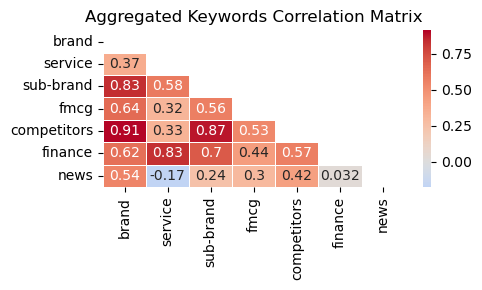

In [104]:
# Plot heatmap for correlations among aggregated keyword trends
corr = df_agg_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(5, 3))
sns.heatmap(corr, 
            mask=mask, 
            cmap='coolwarm', 
            center=0, 
            linewidths=0.5, 
            annot=True)
plt.title("Aggregated Keywords Correlation Matrix")
plt.tight_layout()

#save figure as png
plt.savefig('svi_agg_corr_matrix.png', bbox_inches='tight', dpi=300)

plt.show()

##### 3. Boxplots

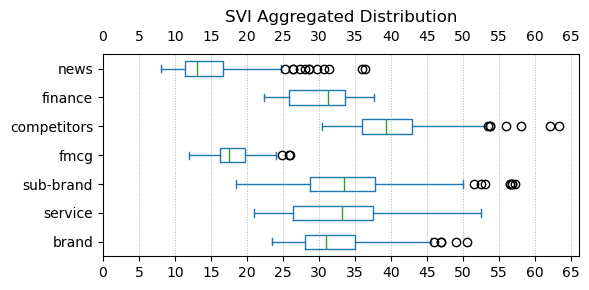

In [105]:
# Boxplot of aggregated keyword search volumes
df_agg_final.plot(kind='box', vert=False, figsize=(6, 3), title='SVI Aggregated Distribution')
plt.tick_params(axis='x', which='both', labeltop=True)
plt.grid(axis='x', linestyle=':', linewidth=0.7)
plt.xticks(np.arange(0, 70, 5))
plt.tight_layout()

#save figure as png
plt.savefig('svi_agg_distribution_boxplot.png', bbox_inches='tight', dpi=300)

plt.show()

##### 4. Time Series Trends

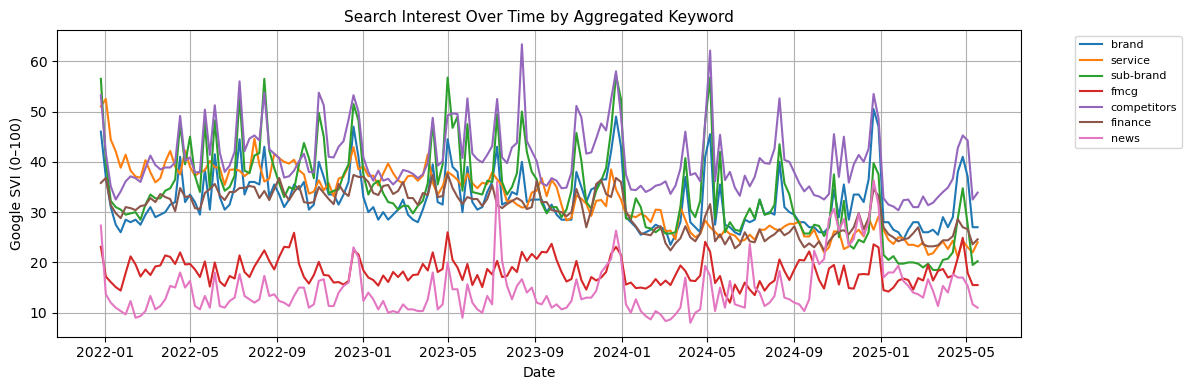

In [106]:
# Plotting all keywords in timeseries
plt.figure(figsize=(12, 4))

for idx, keyword in enumerate(df_agg_final.columns):
    plt.plot(df_agg_final.index, df_agg_final[keyword], label=keyword)

plt.title("Search Interest Over Time by Aggregated Keyword", fontsize=11)
plt.xlabel("Date")
plt.ylabel("Google SVI (0–100)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.grid(True)

#save figure as png
plt.savefig('svi_agg_keyword_trends.png', bbox_inches='tight', dpi=300)

plt.show()

# Carrefour France stock data
This data wascollected att daily and weekly frequenciey.

In [25]:
#read CSV using Spark
df_fin = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_stock_data.csv', header=True, inferSchema=True)
df_wfin = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_stock_weekly.csv', header=True, inferSchema=True)

#### Daily stocks

In [108]:
#show preview daily stocks
df_fin.show(5)
df_fin.printSchema()

+-------------------+------------------+------------------+------------------+------------------+-------+---------+------------+
|               Date|              Open|              High|               Low|             Close| Volume|Dividends|Stock Splits|
+-------------------+------------------+------------------+------------------+------------------+-------+---------+------------+
|2022-01-03 00:00:00|14.412475049746167| 14.45706742372177|14.251939781689956|14.376801490783691|1539521|      0.0|         0.0|
|2022-01-04 00:00:00|14.452608499187328|14.639900207519531|14.381259681986961|14.639900207519531|1921444|      0.0|         0.0|
|2022-01-05 00:00:00|14.622063598058403|15.607569735983143|14.586388336424337|15.384604454040527|7593876|      0.0|         0.0|
|2022-01-06 00:00:00| 15.78594174663718|16.490511113047717|15.607568850763876|16.352272033691406|9738108|      0.0|         0.0|
|2022-01-07 00:00:00| 16.31213981324636|16.624289827380004|16.160523363057166| 16.37010955810547|

#### Weekly stocks

In [109]:
#show preview stocks
df_wfin.show(5)
df_wfin.printSchema()

+-------------------+------------------+------------------+------------------+------------------+--------+---------+------------+
|               Date|              Open|              High|               Low|             Close|  Volume|Dividends|Stock Splits|
+-------------------+------------------+------------------+------------------+------------------+--------+---------+------------+
|2022-01-03 00:00:00|  14.4124747784588|16.624289827380004| 14.25193951342436| 16.37010955810547|25331076|      0.0|         0.0|
|2022-01-10 00:00:00| 16.33889431434613| 16.45929576133611| 15.57189325993142| 15.75472640991211|18968388|      0.0|         0.0|
|2022-01-17 00:00:00|15.821616593224354|16.089175958816803|15.384604833955846|15.661081314086914|16451615|      0.0|         0.0|
|2022-01-24 00:00:00|15.696755275388963|16.098091738872853|15.215149477900288|  15.9375581741333|19400666|      0.0|         0.0|
|2022-01-31 00:00:00| 15.81269534575529|15.843910345110322|14.604224081896566|14.956509590

##### Convert PySpark DataFrame to Pandas to analyse 

In [26]:
# Convert yFinance stock data to pandas
df_wfin = df_wfin.toPandas()

In [27]:
# Check the dimensions of the DataFrame
df_wfin.shape

(177, 8)

### The time issue. 
Upon reviewing the collected datasets, a discrepancy in date labelling was identified between the weekly stock data from `yfinance` and the Google Trends keyword data. To facilitate data comparison and accurate time-series modelling, all datasets must share a standard, synchronised timeframe.

1. *Stock Market Data*

The weekly stock data from `yfinance` uses Monday as the label for each weekly observation. However, each row in the dataset represents the week ending Friday, but is indexed by the preceding Monday.

2. *Google Trends Data*

Google Trends aggregates search interest weekly, with each week's data point labelled by Sunday, the end of the search week.


This results in a misalignment between:
* Stock closing prices (on Friday, labelled as Monday),
* Search volume data (ending Sunday).

The solution to align both datasets:
* Google Trends dates will be shifted −2 days (from Sunday → Friday) to represent the end of the same week as the stock market.
* Stock data dates will be shifted +4 days (from Monday → Friday) to reflect the actual trading day.

This ensures that both data sources are indexed by the same Friday date, making them directly comparable for all subsequent analysis.

##### Adjust Google Trends dates (from Sunday to Friday)

In [28]:
# Align weekly indexes of Google Trends
df_agg_final.index = df_agg_final.index - pd.Timedelta(days=2)

##### Adjust Stock Data dates (from Monday to Friday)

In [29]:
# Align weekly indexes of yFinance
df_wfin['Date'] = pd.to_datetime(df_wfin['Date']) + pd.Timedelta(days=4)

In [30]:
#set date as index
df_wfin.set_index('Date', inplace=True)

In [31]:
# Print date ranges of both datasets to ensure alignment
print('Google Trends')
print(df_agg_final.index.min(), df_agg_final.index.max())
print('yFinance')
print(df_wfin.index.min(), df_wfin.index.max())

Google Trends
2021-12-24 00:00:00 2025-05-16 00:00:00
yFinance
2022-01-07 00:00:00 2025-05-23 00:00:00


There is a date range difference between the two datasets; the `df_agg_final` starts 2 weeks earlier and finishes one week earlier than `df_wfin`.

In [32]:
# Drop the first two weeks from Google Trends
df_svi = df_agg_final.iloc[2:]

# Drop the last week from stock data
df_wfin = df_wfin.iloc[:-1]

In [33]:
# Print date ranges of both datasets to ensure alignment
print('Google Trends')
print(df_svi.index.min(), df_svi.index.max())
print('yFinance')
print(df_wfin.index.min(), df_wfin.index.max())

Google Trends
2022-01-07 00:00:00 2025-05-16 00:00:00
yFinance
2022-01-07 00:00:00 2025-05-16 00:00:00


Now the date has been trimmed to match for both dataset and it is ready to join.

In [34]:
# Get structure of yFinance dataset
df_wfin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 2022-01-07 to 2025-05-16
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          176 non-null    float64
 1   High          176 non-null    float64
 2   Low           176 non-null    float64
 3   Close         176 non-null    float64
 4   Volume        176 non-null    int32  
 5   Dividends     176 non-null    float64
 6   Stock Splits  176 non-null    float64
dtypes: float64(6), int32(1)
memory usage: 10.3 KB


For the aims and objectives set in the methodology, we will only retain the adjusted closing price from the stock market dataframe.

**Why?**
The adjusted closing price reflects the stock’s final trading price after accounting for dividends, splits, and other corporate actions. It provides the most accurate picture of a stock’s actual performance over time, it is especially good for:
* Time-series analysis
* Log-return calculations
* Correlation with external signals (e.g., SVIs)

In [35]:
# Keep only the 'Close' column
df_close = df_wfin[['Close']].copy()

# Renaming column for clarity when merging later
df_close.rename(columns={'Close': 'Carrefour_Close'}, inplace=True)

df_close.head(5)

,Carrefour_Close
Date,
2022-01-07,16.370110
2022-01-14,15.754726
2022-01-21,15.661081
2022-01-28,15.937558
2022-02-04,14.956510


##### 1. Close price over time

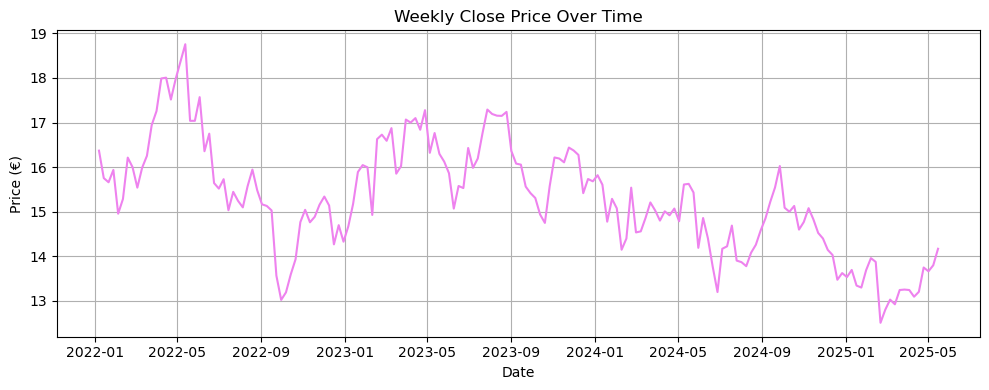

In [37]:
# Plot closing price over time
plt.figure(figsize=(10, 4))
plt.plot(df_close.index, df_close['Carrefour_Close'], label='Close Price', color='violet')
plt.title("Weekly Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (€)")
plt.grid(True)
plt.tight_layout()

#save figure as png
plt.savefig('stock_price_close.png', bbox_inches='tight', dpi=300)

plt.show()

##### 2. Rolling mean

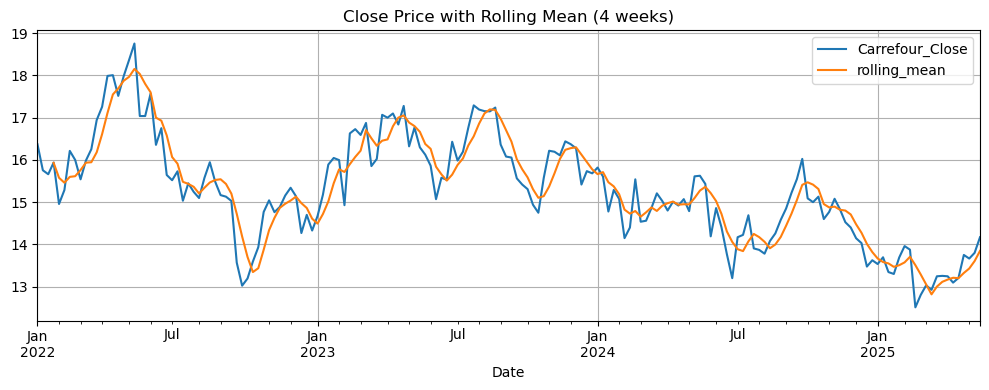

In [38]:
# Rename df to avoid confusion later on
df_rm = df_close
# Plot rolling mean and std deviation of stock price
df_rm['rolling_mean'] = df_rm['Carrefour_Close'].rolling(window=4).mean()
df_rm['rolling_std'] = df_rm['Carrefour_Close'].rolling(window=4).std()

df_rm[['Carrefour_Close', 'rolling_mean']].plot(figsize=(10,4), title='Close Price with Rolling Mean (4 weeks)')
plt.grid(True)
plt.tight_layout()

#save figure as png
plt.savefig('stock_close_price_rolling_mean.png', bbox_inches='tight', dpi=300)

plt.show()

# Merging Datasets: Aggregated SVIs and Price Close Data.

In [39]:
df_merged = df_svi.join(df_close, how='inner')

In [40]:
df_merged.head()

,brand,service,sub-brand,fmcg,competitors,finance,news,Carrefour_Close,rolling_mean,rolling_std
date,,,,,,,,,,
2022-01-07,31.0,44.416667,32.25,16.1,35.125,31.4,12.000000,16.370110,NaN,NaN
2022-01-14,27.5,42.083333,31.00,15.1,32.500,29.8,11.000000,15.754726,NaN,NaN
2022-01-21,26.0,38.833333,30.50,14.4,34.125,28.8,10.333333,15.661081,NaN,NaN
2022-01-28,28.5,41.416667,29.50,17.9,36.125,31.0,9.666667,15.937558,15.930869,0.314531
2022-02-04,28.0,38.250000,29.75,21.2,37.125,30.8,12.333333,14.956510,15.577469,0.429599


In [41]:
df_merged = df_merged.drop(columns=[ "rolling_mean", "rolling_std"])

In [42]:
df_merged.head()

,brand,service,sub-brand,fmcg,competitors,finance,news,Carrefour_Close
date,,,,,,,,
2022-01-07,31.0,44.416667,32.25,16.1,35.125,31.4,12.000000,16.370110
2022-01-14,27.5,42.083333,31.00,15.1,32.500,29.8,11.000000,15.754726
2022-01-21,26.0,38.833333,30.50,14.4,34.125,28.8,10.333333,15.661081
2022-01-28,28.5,41.416667,29.50,17.9,36.125,31.0,9.666667,15.937558
2022-02-04,28.0,38.250000,29.75,21.2,37.125,30.8,12.333333,14.956510


In [43]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 2022-01-07 to 2025-05-16
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            176 non-null    float64
 1   service          176 non-null    float64
 2   sub-brand        176 non-null    float64
 3   fmcg             176 non-null    float64
 4   competitors      176 non-null    float64
 5   finance          176 non-null    float64
 6   news             176 non-null    float64
 7   Carrefour_Close  176 non-null    float64
dtypes: float64(8)
memory usage: 12.4 KB


##### 1. Summary Statistics

In [44]:
# Get summary statistics
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,176.0,32.099432,5.295286,23.500,28.000000,31.000000,35.000000,50.500000
service,176.0,32.191761,6.124816,21.000,26.333333,33.166667,37.270833,44.583333
sub-brand,176.0,33.781250,8.508677,18.500,28.687500,33.250000,37.562500,57.250000
fmcg,176.0,18.111364,2.640711,12.000,16.275000,17.500000,19.700000,26.000000
competitors,176.0,40.322443,6.330262,30.375,35.968750,39.062500,42.906250,63.375000
finance,176.0,30.094318,4.268258,22.400,25.800000,31.200000,33.450000,37.600000
news,176.0,14.651515,5.209249,8.000,11.250000,13.000000,16.666667,36.333333
Carrefour_Close,176.0,15.283888,1.249030,12.510,14.403750,15.214428,16.086926,18.755840
